In [2]:
pip install pymdptoolbox

  Created wheel for pymdptoolbox: filename=pymdptoolbox-4.0b3-py3-none-any.whl size=25659 sha256=9fee66ed136ee18f00e014b22b4802966bde1a996f9094e0a462fddc3dbc3dd3
  Stored in directory: /Users/lasyaakshara/Library/Caches/pip/wheels/38/ba/78/517832a7a3031530ea8ab57010b7335ce8a276ee8662776c2d
Successfully built pymdptoolbox
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install discreteMarkovChain

Note: you may need to restart the kernel to use updated packages.


# Fitted Q Learning

min distance reached 10.057851053160258


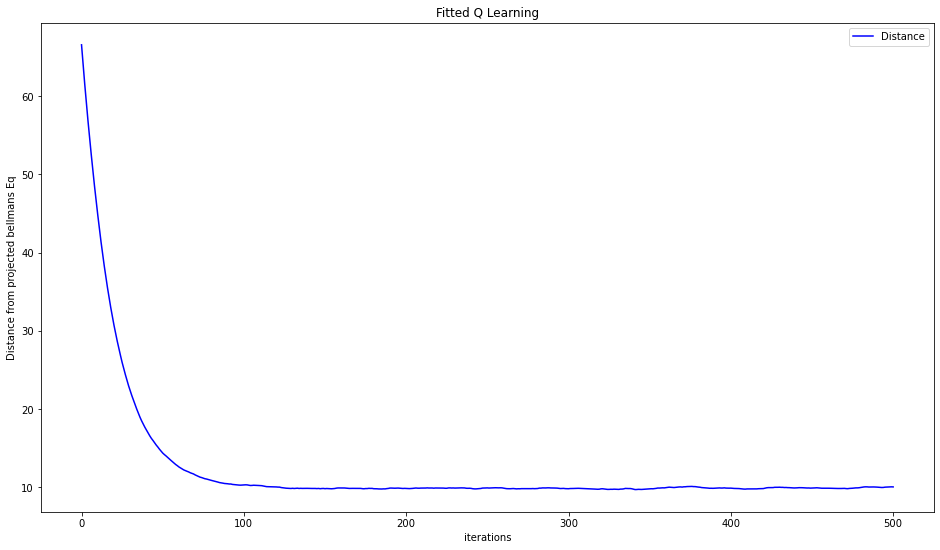

In [29]:
import random
import numpy as np
import time
import matplotlib.pyplot as plt
import mdptoolbox.example
import warnings
from sympy import *
from discreteMarkovChain import markovChain
#warnings.filterwarnings('ignore')

class MarkovDP:
    def __init__(self,s,a):
        self.num_state             = s
        self.num_action            = a
        self.states                = np.array(range(0,s))
        self.actions               = np.array(range(0,a))
        self.transitions           = np.zeros((a,s,s))
        self.rewards               = np.zeros((a,s,s))
        #print(rewards)
        
# The function below initializes transition probability matrix and rewards marks 

    def initialize_mdp(self):      
        np.random.seed(0)        #for reproducibility 
        self.transitions, self.rewards         = mdptoolbox.example.rand(self.num_state,self.num_action)
        self.rewards                           = np.random.rand(self.num_action, self.num_state) #, self.num_state) #,self.num_state)
        #self.rewards                           = np.ones((self.num_action, self.num_state))
        
        
        
class fitted():
    #Initialize Values
    def __init__(self, env, sample_num, gamma = 0.95, d = 10):
        self.env = env
        self.sample_num = sample_num
        self.gamma = gamma
        self.d = d
        self.theta = np.zeros(self.d)
        self.features = np.zeros((30, 10))
        rows = np.shape(self.features)[0]
        cols = np.shape(self.features)[1]
        for i in range(rows):
            for j in range(cols):
                if i == j:
                    self.features[i][j] = 1
                if i == j+10:
                    self.features[i][j] = 1
                if i == j+20:
                    self.features[i][j] = 1
        self.tstar = np.array([[13.43212344333347], [13.27333325333327], [13.973832076666687], [13.611231683333285], [13.47644718333327], [13.505539806666702], [13.627402276666682], [13.561766563333318], [13.404392816666677], [13.512011949998012]])
        self.QTable = np.ones((env.num_state*env.num_action, 1)) #creating Q Table for 
        self.QFunction = np.array([[13.23176522, 13.33925622, 14.05469772], [13.52671959, 13.1224803,  13.22367197], [13.30159516, 13.86810447, 13.51346527], [13.66552722, 13.47151662, 13.23704243], [14.00228974, 13.41027839, 13.44004462], [13.42221627, 13.84567785, 13.56730379], [13.17987508, 13.49701082, 13.59308849], [13.24370111, 13.86450877, 13.89669707], [13.86681663, 13.87073118, 13.73493382], [13.24989143, 13.5198381,  13.37349781]])
        self.QFunction = np.reshape(self.QFunction, (env.num_state*env.num_action, 1)) #reshape to 30 by 1 for purposes of code
        finv = np.linalg.pinv(self.features)
        t = np.linalg.lstsq(self.features, self.QFunction, rcond=None)
        self.th = t[0]
        qs = self.features @ self.th
        
    def createBatch(self):
        batches = []
        for i in range(self.sample_num):
            action = random.choice(self.env.actions)
            #print(self.env.actions)  #[0 1 2]
            action = list(self.env.actions).index(action)
            state = np.random.randint(0, self.env.num_state)
            transitionVector = self.env.transitions[action][state]
            new_state = random.choices(population=self.env.states, weights=list(transitionVector))
            new_state = new_state[0]
            reward = self.env.rewards[action][state]
            experience = (state, action, new_state, reward)
            batches.append(experience)
        return batches
            
    # Behavior Policy- Uniform 
    def action(self, state, epsilon):
        action = random.choice(self.env.actions)
        action = list(self.env.actions).index(action)
        return action
    
    def stoppingConditions(self, N): #did not use as it did not converge to optimal Q Function
        condition = 70   #(2*(self.gamma**N)*(self.B_r) / (1-self.gamma)**2)
        if np.linalg.norm(self.QTable - self.QFunction) < condition:
            return False
        return True
    
    def thetaUpdate(self, A_list, b_list):
        A = sum(A_list)
        b = sum(b_list)
        Ainv = np.linalg.pinv(A)
        self.theta =  Ainv @ b  #np.outer(Ainv, b)   #np.dot(Ainv, b) #lhs/rhs
        return self.theta
        
    def get_Qfunction(self):
        #self.QTable = self.features @ self.theta
        Q = []
        for i in range(self.d):
            Q.append(np.reshape(self.features.T[i], (30,1)) * self.theta[i][0])
        self.QTable = sum(Q)
        return self.QTable # dot product of the feature space and self.theta
    
    def update(self):
        QList = []
        TList = []
        iMatrix = []
        N = 0
        loop = True
        f = self.features 
        while loop:
            batches = self.createBatch() #random.choice()
            A_list = []
            b_list = []
            for batch in batches:
                state, action, new_state, reward = (batch[0], batch[1], batch[2], batch[3])
                sa_pair = (action +  batch[2] * self.env.num_action)
                Q  = np.reshape(self.QTable, (self.env.num_state, self.env.num_action))
                o = reward + (self.gamma)*(np.max(Q[new_state]))
                feature = np.reshape(self.features[sa_pair][np.newaxis], (self.d,1))
                features_transpose = feature.T #[np.newaxis]  #np.transpose(features)
                A = feature @ features_transpose
                A_list.append(A)
                b = feature * o
                b_list.append(b) 
            #UPDATE THETA
            self.thetaUpdate(A_list, b_list)
            #UPDATE Q FUNCTION WITH THETA
            self.get_Qfunction()
            QList.append(np.linalg.norm(self.QTable - self.QFunction))
            #TList.append(np.linalg.norm(self.theta - self.tstar))
            if N==500:
                loop = False
            N+=1
        return QList
            
if __name__ == '__main__':
    ''' Run main program. '''
    start_time = time.time()
    env = MarkovDP(10,3)
    env.initialize_mdp()
    solve = fitted(env, 20000)#MarkovDP) #input how many sample batches you want (I have 5000)
    QList = solve.update()
    print('min distance reached', QList[len(QList)-1])
    fig = plt.figure(figsize=(16,9))
    plt.plot(QList, 
        color = 'b', 
        label = 'Distance')  
    plt.legend(loc ='best')
    plt.title('Fitted Q Learning')
    plt.xlabel('iterations')
    plt.ylabel('Distance from projected bellmans Eq') 
    plt.show()           

To try and fix the problem of not converging to the optimal Q Function we tried to see if the Q Function would converge to a projection of the optimal Q function- however this seemed to have the same problem. However, the Q function is still converging in a significantly smaller number of iterations than seen in past experiments in regular Q Learning. 

# Fitted Q Learning to the Projection of the Q Function

<ipython-input-30-84f674c8d7a6>:75: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  muList = (np.linalg.lstsq( A, b )[0]).tolist()


min distance reached 9.935663210188743


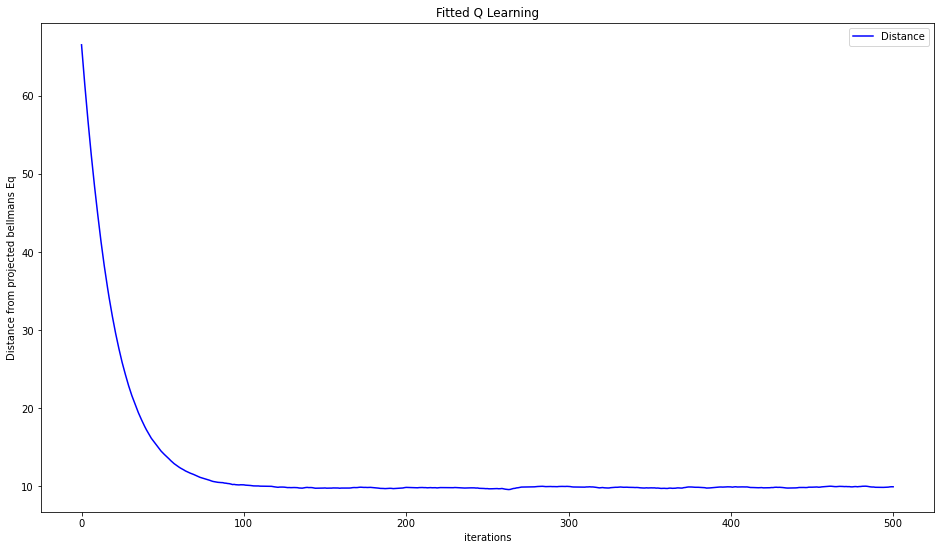

In [30]:
import random
import numpy as np
import time
import matplotlib.pyplot as plt
import mdptoolbox.example
import warnings
from sympy import *
from discreteMarkovChain import markovChain
#warnings.filterwarnings('ignore')

class MarkovDP:
    def __init__(self,s,a):
        self.num_state             = s
        self.num_action            = a
        self.states                = np.array(range(0,s))
        self.actions               = np.array(range(0,a))
        self.transitions           = np.zeros((a,s,s))
        self.rewards               = np.zeros((a,s,s))

    def initialize_mdp(self):      
        np.random.seed(0)        #for reproducibility 
        self.transitions, self.rewards         = mdptoolbox.example.rand(self.num_state,self.num_action)
        self.rewards                           = np.random.rand(self.num_action, self.num_state) #, self.num_state) #,self.num_state)

        
# Going through the code again, I realize it is coded very specifically to the above environment 
#with 10 states and 3 actions (I would need to go back and fix some of it so it can be used with 
#othere environments without trouble)
class fitted():
    #Initialize Values
    def __init__(self, env, sample_num, gamma = 0.95, d = 10): #input environment and how many samples you want for batches, gamma is default 0.95, and d(dimension of theta) is set to 10
        self.env = env 
        self.sample_num = sample_num
        self.gamma = gamma
        self.d = d
        self.theta = np.zeros(self.d)
        self.features = np.zeros((30, 10))
        rows = np.shape(self.features)[0]
        cols = np.shape(self.features)[1]
        for i in range(rows):
            for j in range(cols):
                if i == j:
                    self.features[i][j] = 1
                if i == j+10:
                    self.features[i][j] = 1
                if i == j+20:
                    self.features[i][j] = 1
        self.QTable = np.ones((env.num_state*env.num_action, 1)) #updating Q Function (name a long time ago lol)
        self.QFunction = np.array([[13.23176522, 13.33925622, 14.05469772], [13.52671959, 13.1224803,  13.22367197], [13.30159516, 13.86810447, 13.51346527], [13.66552722, 13.47151662, 13.23704243], [14.00228974, 13.41027839, 13.44004462], [13.42221627, 13.84567785, 13.56730379], [13.17987508, 13.49701082, 13.59308849], [13.24370111, 13.86450877, 13.89669707], [13.86681663, 13.87073118, 13.73493382], [13.24989143, 13.5198381,  13.37349781]])
        #^OPtimal Q Function found through value iteration
        self.QFunction = np.reshape(self.QFunction, (env.num_state*env.num_action, 1))
        finv = np.linalg.pinv(self.features)
        t = np.linalg.lstsq(self.features, self.QFunction, rcond=None)
        self.th = t[0]
        qs = self.features @ self.th

        
    def solveStationary(self):
        #https://dilawarnotes.wordpress.com/2017/11/07/stationary-distribution-of-markov-chains-using-python/
        """ x = xA where x is the answer
        x - xA = 0
        x( I - A ) = 0 and sum(x) = 1
        """
        #print(np.shape(self.env.transitions))
        P = 0
        for a in range(self.env.num_action): # 
            P += (1/3) * self.env.transitions[a]
        A = np.eye(np.shape(P)[0]) - P
        A = np.vstack((A.T, np.ones(np.shape(P)[0])))
        b = np.matrix( [0] * np.shape(P)[0] + [ 1 ] ).T
        muList = (np.linalg.lstsq( A, b )[0]).tolist()
        mus = [0] * (self.env.num_action * self.env.num_state)
        k = 0
        mutotal= 0
        for mu in muList:
            mutotal+=mu[0]
        for mu in range(len(muList)):
            for i in range(self.env.num_action):
                mus[k] = (1/3) * muList[mu][0]
                k += 1
        muMatrix = np.zeros((30 ,30))
        rows = np.shape(muMatrix)[0]
        cols = np.shape(muMatrix)[1]
        for i in range(rows):
            for j in range(cols):
                if i == j:
                    muMatrix[i][j] = mus[i]
        return muMatrix
    
    def projection(self, muMatrix):
        features_transpose = self.features.T
        #take the inverse of the F^-1 (mu) F
        projOperator1 = np.linalg.pinv(np.linalg.multi_dot([features_transpose, muMatrix, self.features]))
        #multiply by the optimal Q Function found through value iteration
        proj = np.linalg.multi_dot([self.features, projOperator1, features_transpose, muMatrix, self.QFunction]) 
        return proj
        
    def createBatch(self):
        batches = []
        for i in range(self.sample_num):
            action = random.choice(self.env.actions)
            #print(self.env.actions)  #[0 1 2]
            action = list(self.env.actions).index(action)
            state = np.random.randint(0, self.env.num_state)
            transitionVector = self.env.transitions[action][state]
            new_state = random.choices(population=self.env.states, weights=list(transitionVector))
            new_state = new_state[0]
            reward = self.env.rewards[action][state]
            experience = (state, action, new_state, reward)
            batches.append(experience)
        return batches
            
    # Behavior Policy- Uniform
    def action(self, state, epsilon):
        action = random.choice(self.env.actions)
        action = list(self.env.actions).index(action)
        return action
    
    def stoppingConditions(self, N):
        condition = 70   #(2*(self.gamma**N)*(self.B_r) / (1-self.gamma)**2)
        if np.linalg.norm(self.QTable - self.QFunction) < condition:
            return False
        return True
    
    def thetaUpdate(self, A_list, b_list):
        A = sum(A_list)
        b = sum(b_list)
        Ainv = np.linalg.pinv(A)
        self.theta =  Ainv @ b  #np.outer(Ainv, b)   #np.dot(Ainv, b) #lhs/rhs
        return self.theta
        
        
    def get_Qfunction(self):
        #self.QTable = self.features @ self.theta
        Q = []
        for i in range(self.d):
            Q.append(np.reshape(self.features.T[i], (30,1)) * self.theta[i][0])
        self.QTable = sum(Q)
        return self.QTable # dot product of the feature space and self.theta
       
    #https://stackoverflow.com/questions/62362167/check-if-matrix-is-scalar-multiple-of-another-python
    def is_scalar_multiple(self, A, B):    
        possibleAnswer = A[0][0]/B[0][0] # if they are scalar multiples, this will be the answer
        errorLimit = 10e-10 # our error tolerance, it might be that our floats don't match exactly but according to this error limit they have to match till 11th decimal
        # checking one element at a time
        for i,v in enumerate(A):
            for j in range(len(v)):
                if abs(A[i][j]-(B[i][j]*possibleAnswer))>errorLimit:
                    return False # even if one element fails return False
        return possibleAnswer # if everything goes correct return the possible answer
    
    def update(self):
        QList = []
        iMatrix = []
        N = 0
        loop = True
        stationary = self.solveStationary() #solve stationary markov values
        projection = self.projection(stationary) #this gives the projected phi(theta) of the target Q function 
        f = self.features 
        while loop:
            batches = self.createBatch() #random.choice()
            #print(batches)
            #break
            A_list = []
            b_list = []
            for batch in batches:
                state, action, new_state, reward = (batch[0], batch[1], batch[2], batch[3])
                sa_pair = (action +  batch[2] * self.env.num_action)
                Q  = np.reshape(self.QTable, (self.env.num_state, self.env.num_action))
                o = reward + (self.gamma)*(np.max(Q[new_state]))
                feature = np.reshape(self.features[sa_pair][np.newaxis], (self.d,1))
                features_transpose = feature.T #[np.newaxis]  #np.transpose(features)
                A = feature @ features_transpose
                A_list.append(A)
                b = feature * o
                b_list.append(b) 
            #UPDATE THETA
            self.thetaUpdate(A_list, b_list)
            #UPDATE Q FUNCTION WITH THETA
            self.get_Qfunction()
            QList.append(np.linalg.norm(self.QTable - projection)) #self.QFunction))
            if N==500:
                loop = False
            N+=1
        projection = self.projection(stationary)
        return QList
            
if __name__ == '__main__':
    ''' Run main program. '''
    start_time = time.time()
    env = MarkovDP(10,3)
    env.initialize_mdp()
    solve = fitted(env, 20000)#MarkovDP)
    QList = solve.update()
    print('min distance reached', QList[len(QList)-1])
    fig = plt.figure(figsize=(16,9))
    plt.plot(QList, 
        color = 'b', 
        label = 'Distance')  
    plt.legend(loc ='best')
    plt.title('Fitted Q Learning')
    plt.xlabel('iterations')
    plt.ylabel('Distance from projected bellmans Eq') 
    plt.show()           

Although we attempeted to fix the problem the results were inonclusive as the Q function did not converge to the projection of the Q Function either.